In [41]:
import requests # library to handle requests
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
# import k-means from clustering stage
from sklearn.cluster import KMeans

import pandas as pd
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy import distance
print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


# Define reference address and destination address

In [42]:
address_ref = 'Stuttgart Vaihingen'
address_dest='Berlin, Platz der Republik 1'
search_radius=15


geolocator_ref = Nominatim(user_agent="foursquare_agent")
location_ref = geolocator_ref.geocode(address_ref)
latitude_ref = location_ref.latitude
longitude_ref = location_ref.longitude
print(latitude_ref, longitude_ref)

geolocator_dest = Nominatim(user_agent="foursquare_agent")
location_dest = geolocator_dest.geocode(address_dest)
latitude_dest = location_dest.latitude
longitude_dest = location_dest.longitude
print(latitude_dest, longitude_dest)

48.7264626 9.1131764
52.51865325 13.37610135409873


In [43]:
# create map of New York using latitude and longitude values
map_start= folium.Map(location=[(latitude_ref+latitude_dest)/2, (longitude_ref+latitude_dest)/2], zoom_start=5)

# add markers to map
    
label = 'Reference'
label = folium.Popup(label, parse_html=True)
folium.CircleMarker(
        [latitude_ref, longitude_ref],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_start)  
label = 'Destination'
label = folium.Popup(label, parse_html=True)
folium.CircleMarker(
        [latitude_dest, longitude_dest],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_start)   
map_start

## Get German Address and Cooridnate Data from opendatasoft.com

In [44]:
url = 'https://public.opendatasoft.com/api/records/1.0/search/?dataset=postleitzahlen-deutschland&q=&rows=10000&facet=note&facet=plz'
results = requests.get(url).json()

In [45]:
type(results)
res1=results['records']
dataframe = pd.json_normalize(res1)
dataframe=dataframe[['fields.note','fields.plz','fields.geo_point_2d']]
dataframe.columns=['city','post code', 'coordinates']
print(dataframe.shape)
dataframe.dropna(inplace=True)
print(dataframe.shape)

(8699, 3)
(8697, 3)


## Filter only cities which are close to the destination area

In [46]:
coordinates=dataframe['coordinates'].to_list()
dist=[]
lat=[]
long=[]
for coor in coordinates:
    dist.append(distance.distance([latitude_dest, longitude_dest],coor).km)
    lat.append(coor[0])
    long.append(coor[1])
dataframe['distance']=dist
dataframe['latitude']=lat
dataframe['longitude']=long
destination_data=dataframe[dataframe['distance']<search_radius]
destination_data.reset_index(inplace=True)
print(destination_data.shape)
destination_data.head()

(186, 7)


,index,city,post code,coordinates,distance,latitude,longitude
0,10,Berlin Westend,14052,"[52.515925196771384, 13.256069555210905]",8.153842,52.515925,13.256070
1,31,Berlin Neukölln,12057,"[52.468382478984736, 13.46318165105761]",8.140878,52.468382,13.463182
2,68,Berlin Friedrichshain,10249,"[52.52381194391551, 13.442878223142598]",4.568854,52.523812,13.442878
3,247,Berlin Französisch Buchholz,13127,"[52.61880913270147, 13.433471475808405]",11.804499,52.618809,13.433471
4,269,Berlin,12307,"[52.388808935596224, 13.39020168220143]",14.480312,52.388809,13.390202


In [47]:
coord_df=destination_data[['city','latitude','longitude', 'post code']]
coord_df.columns=['Neighborhood','Latitude','Longitude', 'Post Code']
ref_data={'Neighborhood':'Reference', 'Latitude':latitude_ref, 'Longitude':longitude_ref,'Post Code':1}
coord_df = coord_df.append(ref_data, ignore_index=True)
coord_df.head()

,Neighborhood,Latitude,Longitude,Post Code
0,Berlin Westend,52.515925,13.256070,14052
1,Berlin Neukölln,52.468382,13.463182,12057
2,Berlin Friedrichshain,52.523812,13.442878,10249
3,Berlin Französisch Buchholz,52.618809,13.433471,13127
4,Berlin,52.388809,13.390202,12307


## Get Foursquare Data

In [48]:
CLIENT_ID = 'LWZBDYZVEVF4PTOAA25AH0HZ20XVHTTJ21QIA0J4BN0TJURE' # your Foursquare ID
CLIENT_SECRET = 'GPUKLHZYBRLLVRENUTRTZDVE1VQONPKTHGDHN5KFNYPBMP01' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LWZBDYZVEVF4PTOAA25AH0HZ20XVHTTJ21QIA0J4BN0TJURE
CLIENT_SECRET:GPUKLHZYBRLLVRENUTRTZDVE1VQONPKTHGDHN5KFNYPBMP01


In [49]:
url='https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION)
categories = requests.get(url).json()
cat=categories['response']['categories']
cat_df = pd.json_normalize(cat)

In [50]:
cat_df=cat_df[['name','categories']]
cat_df['categories'][0][0]['name']
new_cat=[]
for main_cat in cat_df['categories']:
    sub_cats=[]
    for sub_cat in main_cat:
        sub_cats.append(sub_cat['name'])
    new_cat.append(sub_cats)
cat_df['sub categories']=new_cat
cat_df.drop('categories',axis=1, inplace=True)
print(cat_df.shape)
cat_df.head()

(10, 2)


,name,sub categories
0,Arts & Entertainment,"[Amphitheater, Aquarium, Arcade, Art Gallery, ..."
1,College & University,"[College Academic Building, College Administra..."
2,Event,"[Christmas Market, Conference, Convention, Fes..."
3,Food,"[Afghan Restaurant, African Restaurant, Americ..."
4,Nightlife Spot,"[Bar, Brewery, Lounge, Night Market, Nightclub..."


In [51]:
def getCategorie(searchCat,categories_df):
    mainCategorie=searchCat
    ii=-1
    for item in categories_df['sub categories']:
        ii=ii+1
        if searchCat in item:
            index=ii
            mainCategorie=categories_df['name'][index]
            break
        
    
    return(mainCategorie)


In [52]:
getCategorie('xyz', cat_df)

'xyz'

In [53]:
def getNearbyVenues(postcode, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for zcode, lat, lng in zip(postcode, latitudes, longitudes):
        print(zcode)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&sortByPopularity={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            RADIUS, 
            LIMIT,
            sortbypop)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
            # return only relevant information for each nearby venue
            venues_list.append([(
                zcode,
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                getCategorie(v['venue']['categories'][0]['name'],cat_df)) for v in results])
        except:
            print(str(zcode)+' no venues generated')
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Post Code',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [54]:
def getNearbyVenuesNoCat(postcode, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for zcode, lat, lng in zip(postcode, latitudes, longitudes):
        print(zcode)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&sortByPopularity={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            RADIUS, 
            LIMIT,
            sortbypop)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
            # return only relevant information for each nearby venue
            venues_list.append([(
                zcode,
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            print(str(zcode)+' no venues generated')
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Post Code',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [55]:
LIMIT=50
RADIUS=1000
sortbypop=1
destination_venues = getNearbyVenuesNoCat(destination_data['post code'],
                                   latitudes=destination_data['latitude'],
                                   longitudes=destination_data['longitude']
                                  )

14052
12057
10249
13127
12307
14193
12247
12207
12209
14165
10405
12059
12619
10963
10318
10559
14129
10315
12355
12309
12049
12685
10969
13467
12105
12279
13187
12459
10243
12305
13053
13587
13595
10437
13509
10627
10551
10367
12687
13088
12051
13407
13159
13403
12169
13439
13409
13189
10999
10829
13059
12059
13089
12353
13597
12043
13583
12107
12099
13581
12157
13505
10439
12487
10557
14169
12165
10783
12623
12435
13465
16548
10997
14059
13593
10625
10623
10709
10715
10117
13156
13055
10179
10961
12681
10317
13585
10779
10707
12679
13057
12103
10585
12357
14055
10623
12689
10781
10713
12203
10245
12053
14167
14057
10711
13357
13435
10777
12159
10119
14199
13086
10365
13599
10409
13469
13347
13355
10967
13359
13503
12683
10115
13051
10785
10247
10587
12629
12439
10823
10178
10369
12621
12347
12437
12489
10407
10789
10589
10319
10827
10555
12055
12109
12351
13405
13351
12249
13129
13437
12045
14053
13627
13629
13158
12205
12101
13507
12305
14050
12163
10965
10719
12277
10553
14163
1062

In [56]:
print('There are {} uniques categories.'.format(len(destination_venues['Venue Category'].unique())))
print(destination_venues.shape)
destination_venues.head()

There are 349 uniques categories.
(6084, 7)


,Post Code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,14052,52.515925,13.25607,S Heerstraße,52.508120,13.259230,Light Rail Station
1,14052,52.515925,13.25607,S Olympiastadion,52.511425,13.243355,Light Rail Station
2,14052,52.515925,13.25607,Olympischer Platz,52.515356,13.245647,Plaza
3,14052,52.515925,13.25607,Westend Klause,52.516494,13.260109,Bar
4,14052,52.515925,13.25607,Adik's Stehcafe,52.507889,13.258131,Café


In [57]:
LIMIT=50
RADIUS=1000
sortbypop=1
destination_venues = getNearbyVenues(destination_data['post code'],
                                   latitudes=destination_data['latitude'],
                                   longitudes=destination_data['longitude']
                                  )

14052
12057
10249
13127
12307
14193
12247
12207
12209
14165
10405
12059
12619
10963
10318
10559
14129
10315
12355
12309
12049
12685
10969
13467
12105
12279
13187
12459
10243
12305
13053
13587
13595
10437
13509
10627
10551
10367
12687
13088
12051
13407
13159
13403
12169
13439
13409
13189
10999
10829
13059
12059
13089
12353
13597
12043
13583
12107
12099
13581
12157
13505
10439
12487
10557
14169
12165
10783
12623
12435
13465
16548
10997
14059
13593
10625
10623
10709
10715
10117
13156
13055
10179
10961
12681
10317
13585
10779
10707
12679
13057
12103
10585
12357
14055
10623
12689
10781
10713
12203
10245
12053
14167
14057
10711
13357
13435
10777
12159
10119
14199
13086
10365
13599
10409
13469
13347
13355
10967
13359
13503
12683
10115
13051
10785
10247
10587
12629
12439
10823
10178
10369
12621
12347
12437
12489
10407
10789
10589
10319
10827
10555
12055
12109
12351
13405
13351
12249
13129
13437
12045
14053
13627
13629
13158
12205
12101
13507
12305
14050
12163
10965
10719
12277
10553
14163
1062

In [58]:
print('There are {} uniques categories.'.format(len(destination_venues['Venue Category'].unique())))
print(destination_venues.shape)
destination_venues.head()

There are 125 uniques categories.
(6084, 7)


,Post Code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,14052,52.515925,13.25607,S Heerstraße,52.508120,13.259230,Travel & Transport
1,14052,52.515925,13.25607,S Olympiastadion,52.511425,13.243355,Travel & Transport
2,14052,52.515925,13.25607,Olympischer Platz,52.515356,13.245647,Outdoors & Recreation
3,14052,52.515925,13.25607,Westend Klause,52.516494,13.260109,Nightlife Spot
4,14052,52.515925,13.25607,Adik's Stehcafe,52.507889,13.258131,Food


## Get Venues of Reference Neighborhood

In [59]:
LIMIT=100
RADIUS=3000
sortbypop=1
reference_venues = getNearbyVenues([1],
                                   [latitude_ref],
                                   [longitude_ref]
                                  )
print(reference_venues.shape)
reference_venues.head()

1
(85, 7)


,Post Code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,48.726463,9.113176,Kaufland,48.730489,9.108693,Shop & Service
1,1,48.726463,9.113176,Kaufland,48.731037,9.150364,Shop & Service
2,1,48.726463,9.113176,S Stuttgart-Rohr,48.717724,9.108438,Travel & Transport
3,1,48.726463,9.113176,Pullman Hotel Stuttgart Fontana,48.726487,9.111428,Travel & Transport
4,1,48.726463,9.113176,Ibis Styles Hotel,48.727384,9.117308,Travel & Transport


In [60]:
all_venues=pd.concat([destination_venues, reference_venues],ignore_index=True)
print(all_venues.shape)
all_venues.head()

(6169, 7)


,Post Code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,14052,52.515925,13.25607,S Heerstraße,52.508120,13.259230,Travel & Transport
1,14052,52.515925,13.25607,S Olympiastadion,52.511425,13.243355,Travel & Transport
2,14052,52.515925,13.25607,Olympischer Platz,52.515356,13.245647,Outdoors & Recreation
3,14052,52.515925,13.25607,Westend Klause,52.516494,13.260109,Nightlife Spot
4,14052,52.515925,13.25607,Adik's Stehcafe,52.507889,13.258131,Food


## Count Venues per Neighborhood

In [61]:
hoods=all_venues.groupby('Post Code').count()
hoods=hoods[['Venue']]
hoods.columns = ['Value Count'] 
print(hoods.shape)
print(hoods.head())
hood_list=hoods.index.to_list()
if 1 in hood_list:
    print('Reference included')

(181, 1)
           Value Count
Post Code             
1                   85
10115               50
10117               50
10119               50
10178               50
Reference included


## Prepare Data for Clustering

In [62]:
df_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
#df_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
hoods_temp= all_venues['Post Code'] 
df_onehot.insert(0, 'Post Code', hoods_temp)
# move neighborhood column to the first column
#fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
#toronto_onehot = toronto_onehot[fixed_columns]
print(df_onehot.shape)
df_onehot.head()

(6169, 127)


,Post Code,Advertising Agency,Airport Lounge,Airport Service,Argentinian Restaurant,Art Museum,Arts & Entertainment,Bavarian Restaurant,Bed & Breakfast,Beer Bar,...,Venezuelan Restaurant,Vietnamese Restaurant,Volleyball Court,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo Exhibit
0,14052,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,14052,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14052,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14052,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14052,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
df_grouped = df_onehot.groupby('Post Code').mean().reset_index()
hood_list=df_grouped['Post Code']
if 1 in hood_list:
    print('Reference included')
print(df_grouped.shape)
df_grouped.head()

Reference included
(181, 127)


,Post Code,Advertising Agency,Airport Lounge,Airport Service,Argentinian Restaurant,Art Museum,Arts & Entertainment,Bavarian Restaurant,Bed & Breakfast,Beer Bar,...,Venezuelan Restaurant,Vietnamese Restaurant,Volleyball Court,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo Exhibit
0,1,0.0,0.0,0.0,0.0,0.00,0.011765,0.00,0.0,0.00,...,0.0,0.00,0.00,0.0,0.0,0.011765,0.0,0.0,0.0,0.0
1,10115,0.0,0.0,0.0,0.0,0.02,0.040000,0.00,0.0,0.04,...,0.0,0.02,0.02,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,10117,0.0,0.0,0.0,0.0,0.02,0.060000,0.02,0.0,0.00,...,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,10119,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.0,0.06,...,0.0,0.02,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,10178,0.0,0.0,0.0,0.0,0.02,0.000000,0.00,0.0,0.04,...,0.0,0.02,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


## Remove all categories that are not available in Reference

(181, 20)
Index(['Post Code', 'Arts & Entertainment', 'Chinese Restaurant',
       'Climbing Gym', 'Farmers Market', 'Food', 'Gym / Fitness Center',
       'Hotel Pool', 'Ice Cream Shop', 'Nightlife Spot',
       'Outdoors & Recreation', 'Professional & Other Places',
       'Shop & Service', 'Supermarket', 'Sushi Restaurant',
       'Swabian Restaurant', 'Thai Restaurant', 'Trattoria/Osteria',
       'Travel & Transport', 'Wine Shop'],
      dtype='object')


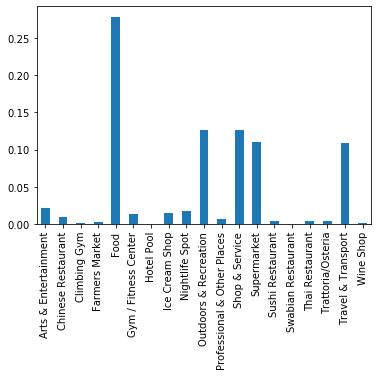

In [64]:
df_grouped_ref=df_grouped[df_grouped['Post Code']==1]
index=df_grouped_ref!=0
index2=index.values.tolist()
df_grouped=df_grouped.loc[:,index2[0]]
df_grouped_ref=df_grouped[df_grouped['Post Code']==1]
print(df_grouped.shape)
print(df_grouped.columns)
df_grouped.head()
df_grouped.mean().plot(kind='bar')

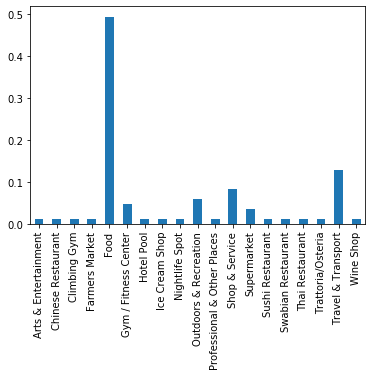

In [65]:
df_grouped_ref_plot=df_grouped_ref.drop('Post Code',axis=1)
df_grouped_ref_plot.mean().plot(kind='bar')

In [66]:
df_grouped_count=pd.merge(df_grouped,hoods,on='Post Code')
df_grouped_filtered=df_grouped_count[df_grouped_count['Value Count']>9]
df_grouped_filtered.drop(columns='Value Count',inplace=True)
df_grouped.reset_index(inplace=True)
print(df_grouped_filtered.shape)
df_grouped_filtered.head(38)

(157, 20)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Post Code,Arts & Entertainment,Chinese Restaurant,Climbing Gym,Farmers Market,Food,Gym / Fitness Center,Hotel Pool,Ice Cream Shop,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Supermarket,Sushi Restaurant,Swabian Restaurant,Thai Restaurant,Trattoria/Osteria,Travel & Transport,Wine Shop
0,1,0.011765,0.011765,0.011765,0.011765,0.494118,0.047059,0.011765,0.011765,0.011765,0.058824,0.011765,0.082353,0.035294,0.011765,0.011765,0.011765,0.011765,0.129412,0.011765
1,10115,0.040000,0.000000,0.000000,0.000000,0.360000,0.020000,0.000000,0.000000,0.000000,0.060000,0.000000,0.040000,0.060000,0.000000,0.000000,0.000000,0.020000,0.080000,0.000000
2,10117,0.060000,0.000000,0.000000,0.000000,0.160000,0.060000,0.000000,0.000000,0.000000,0.120000,0.000000,0.160000,0.080000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000
3,10119,0.000000,0.000000,0.000000,0.000000,0.520000,0.060000,0.000000,0.000000,0.000000,0.140000,0.000000,0.040000,0.040000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000
4,10178,0.000000,0.000000,0.000000,0.000000,0.220000,0.080000,0.000000,0.000000,0.000000,0.160000,0.000000,0.100000,0.020000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000
5,10179,0.020000,0.000000,0.000000,0.000000,0.160000,0.020000,0.000000,0.000000,0.080000,0.060000,0.060000,0.140000,0.080000,0.000000,0.020000,0.000000,0.000000,0.200000,0.000000
6,10243,0.040000,0.000000,0.000000,0.000000,0.220000,0.020000,0.000000,0.000000,0.080000,0.060000,0.020000,0.120000,0.120000,0.000000,0.000000,0.000000,0.000000,0.180000,0.000000
7,10245,0.020000,0.000000,0.000000,0.000000,0.360000,0.020000,0.000000,0.020000,0.160000,0.100000,0.000000,0.000000,0.020000,0.000000,0.000000,0.020000,0.000000,0.040000,0.000000
8,10247,0.000000,0.000000,0.000000,0.020000,0.400000,0.040000,0.000000,0.040000,0.060000,0.080000,0.000000,0.100000,0.000000,0.000000,0.000000,0.060000,0.000000,0.020000,0.000000
9,10249,0.020000,0.000000,0.000000,0.000000,0.260000,0.000000,0.000000,0.000000,0.020000,0.280000,0.000000,0.040000,0.120000,0.000000,0.000000,0.000000,0.000000,0.060000,0.000000


In [67]:
num_top_venues = 4

for hood in df_grouped_filtered['Post Code']:
    print(hood)
    temp = df_grouped_filtered[df_grouped_filtered['Post Code'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

1
                   venue  freq
0                   Food  0.49
1     Travel & Transport  0.13
2         Shop & Service  0.08
3  Outdoors & Recreation  0.06


10115
                   venue  freq
0                   Food  0.36
1     Travel & Transport  0.08
2  Outdoors & Recreation  0.06
3            Supermarket  0.06


10117
                   venue  freq
0         Shop & Service  0.16
1                   Food  0.16
2  Outdoors & Recreation  0.12
3     Travel & Transport  0.10


10119
                   venue  freq
0                   Food  0.52
1  Outdoors & Recreation  0.14
2   Gym / Fitness Center  0.06
3         Shop & Service  0.04


10178
                   venue  freq
0                   Food  0.22
1  Outdoors & Recreation  0.16
2         Shop & Service  0.10
3     Travel & Transport  0.10


10179
                venue  freq
0  Travel & Transport  0.20
1                Food  0.16
2      Shop & Service  0.14
3      Nightlife Spot  0.08


10243
                venue  freq
0      

# Clustering

In [68]:
# set number of clusters
kclusters = 5

df_grouped_clustering = df_grouped_filtered.drop('Post Code', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([3, 3, 2, 3, 1, 2, 1, 3, 3, 0, 1, 0, 3, 4, 0, 4, 2, 3, 1, 4, 3, 3,
       1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 2, 1,
       3, 3, 1, 2, 2, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 1, 3, 2, 2, 1, 2, 1, 1, 1, 3, 1, 2, 1, 0, 0, 1, 1, 4, 0, 0, 1,
       4, 1, 1, 2, 0, 1, 2, 2, 1, 4, 1, 1, 1, 3, 4, 1, 4, 4, 0, 0, 2, 0,
       0, 4, 2, 1, 1, 0, 2, 1, 4, 1, 1, 3, 1, 1, 1, 1, 3, 3, 4, 1, 2, 4,
       2, 1, 2, 3, 4, 2, 4, 4, 1, 0, 2, 4, 0, 1, 1, 1, 0, 3, 3, 1, 2, 1,
       3, 3, 3], dtype=int32)

In [69]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
  #  print(row_categories)
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [70]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Post Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Post Code'] = df_grouped_filtered['Post Code']

for ind in np.arange(df_grouped_filtered.shape[0]):
    
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped_filtered.iloc[ind, 1:], num_top_venues)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()


(157, 6)


,Post Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1,Food,Travel & Transport,Shop & Service,Outdoors & Recreation,Gym / Fitness Center
1,10115,Food,Travel & Transport,Outdoors & Recreation,Supermarket,Shop & Service
2,10117,Food,Shop & Service,Outdoors & Recreation,Travel & Transport,Supermarket
3,10119,Food,Outdoors & Recreation,Gym / Fitness Center,Supermarket,Shop & Service
4,10178,Food,Outdoors & Recreation,Shop & Service,Travel & Transport,Gym / Fitness Center


In [71]:
# add clustering labels
try:
    neighborhoods_venues_sorted.drop(columns='Cluster Labels', inplace=True)
except:
    print('No Cluster lables')

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()
#toronto_merged = toronto_city_filtered

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_merged=pd.merge(coord_df,neighborhoods_venues_sorted,on='Post Code')
#toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
print(df_merged.shape)
df_merged.head() # check the last columns!

No Cluster lables
(163, 10)


,Neighborhood,Latitude,Longitude,Post Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Berlin Westend,52.515925,13.256070,14052,1,Food,Shop & Service,Travel & Transport,Outdoors & Recreation,Chinese Restaurant
1,Berlin Neukölln,52.468382,13.463182,12057,1,Food,Travel & Transport,Shop & Service,Supermarket,Outdoors & Recreation
2,Berlin Friedrichshain,52.523812,13.442878,10249,0,Outdoors & Recreation,Food,Supermarket,Travel & Transport,Shop & Service
3,Berlin Lankwitz,52.439465,13.346205,12247,0,Food,Outdoors & Recreation,Supermarket,Shop & Service,Ice Cream Shop
4,Berlin Lichtenfelde,52.419783,13.313297,12207,4,Shop & Service,Food,Supermarket,Travel & Transport,Chinese Restaurant


In [72]:
df_ref=df_merged[df_merged['Post Code']==1]
ref_cluster=df_ref['Cluster Labels'].to_list()
ref_cluster=ref_cluster[0]
print(ref_cluster)
df_merged_wo_reference=df_merged[df_merged['Post Code']!=1]
df_ref.head()

3


,Neighborhood,Latitude,Longitude,Post Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
162,Reference,48.726463,9.113176,1,3,Food,Travel & Transport,Shop & Service,Outdoors & Recreation,Gym / Fitness Center


### Show all possible neighborhoods

In [82]:
# create map
map_clusters = folium.Map(location=[latitude_dest, longitude_dest], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged_wo_reference['Latitude'], df_merged_wo_reference['Longitude'], df_merged_wo_reference['Neighborhood'], df_merged_wo_reference['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
            [lat, lon],
            radius=7,
            popup=label,
            color=rainbow[0],
            fill=True,
            fill_color=rainbow[0],
            fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Show candidate neighborhoods

In [73]:
# create map
map_clusters = folium.Map(location=[latitude_dest, longitude_dest], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged_wo_reference['Latitude'], df_merged_wo_reference['Longitude'], df_merged_wo_reference['Neighborhood'], df_merged_wo_reference['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if cluster==ref_cluster:
        folium.CircleMarker(
            [lat, lon],
            radius=7,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
    else:
        folium.CircleMarker(
            [lat, lon],
            radius=2,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [74]:
df_candidate=df_merged[df_merged['Cluster Labels']==ref_cluster]
print(df_candidate.shape)
df_candidate.head()

(45, 10)


,Neighborhood,Latitude,Longitude,Post Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,Berlin Prenzlauer Berg,52.535159,13.425551,10405,3,Food,Outdoors & Recreation,Gym / Fitness Center,Supermarket,Travel & Transport
6,Berlin Neukölln,52.487414,13.443446,12059,3,Food,Outdoors & Recreation,Supermarket,Nightlife Spot,Thai Restaurant
7,Berlin Neukölln,52.480137,13.452204,12059,3,Food,Outdoors & Recreation,Supermarket,Nightlife Spot,Thai Restaurant
10,Berlin Karlshorst,52.483417,13.529034,10318,3,Food,Outdoors & Recreation,Shop & Service,Travel & Transport,Supermarket
15,Berlin Neukölln,52.476231,13.422627,12049,3,Food,Nightlife Spot,Outdoors & Recreation,Supermarket,Ice Cream Shop


## Add distance to destination point and find closest candidate neighborhoods

In [75]:
distances=destination_data[['post code','distance']]
distances.columns=['Post Code','Distance']
print(distances.shape)
distances.head()

(186, 2)


,Post Code,Distance
0,14052,8.153842
1,12057,8.140878
2,10249,4.568854
3,13127,11.804499
4,12307,14.480312


In [76]:
df_candidate=pd.merge(df_candidate,distances,on='Post Code')
df_candidate.sort_values(by=['Distance'], inplace=True)

In [77]:
print(df_candidate.shape)
df_candidate[['Neighborhood','Post Code','Distance']].head()

(46, 11)


,Neighborhood,Post Code,Distance
33,Berlin Mitte,10115,1.609431
28,Berlin Mitte,10119,2.380342
15,Berlin Schöneberg,10783,2.644311
37,Berlin Moabit,10555,2.773316
10,Berlin Moabit,10551,2.968130


## Plot cluster centroids

In [78]:
centroids=kmeans.cluster_centers_
cluster_cat=df_grouped_filtered.columns.tolist()
cluster_cat=cluster_cat[1:]

In [79]:
d = {'Categories': cluster_cat, 'Frequency Cluster 0': (centroids[0]),'Frequency Cluster 1': (centroids[1]),'Frequency Cluster 2': (centroids[2]),'Frequency Cluster 3': (centroids[3]),'Frequency Cluster 4': (centroids[4])}
centre_cat = pd.DataFrame(data=d)
centre_cat.head()


,Categories,Frequency Cluster 0,Frequency Cluster 1,Frequency Cluster 2,Frequency Cluster 3,Frequency Cluster 4
0,Arts & Entertainment,2.724962e-02,0.021121,0.035519,0.018338,2.310851e-02
1,Chinese Restaurant,9.599570e-03,0.013865,0.001337,0.007112,1.242298e-02
2,Climbing Gym,1.644737e-03,0.001739,0.000909,0.003676,0.000000e+00
3,Farmers Market,8.673617e-19,0.002748,0.002330,0.007086,8.673617e-19
4,Food,1.747943e-01,0.309381,0.155623,0.421578,1.521135e-01


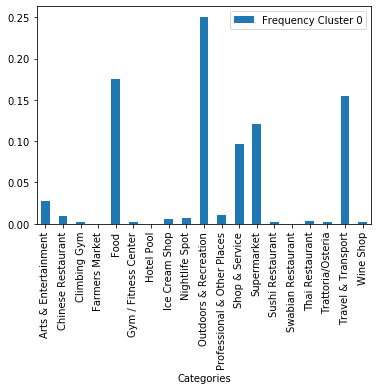

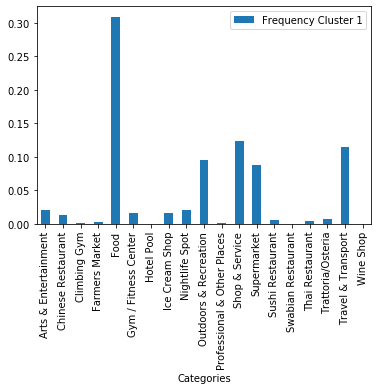

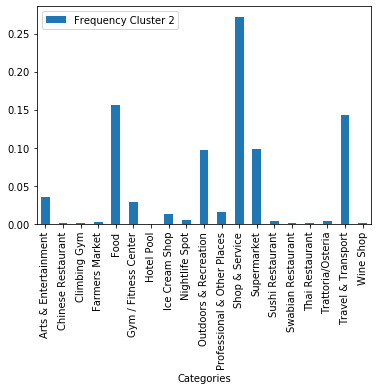

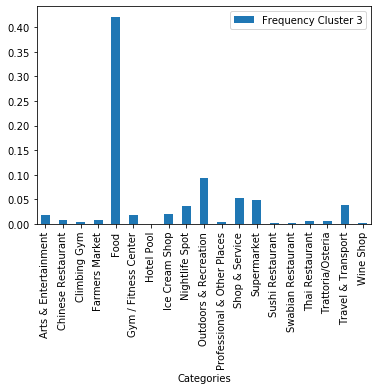

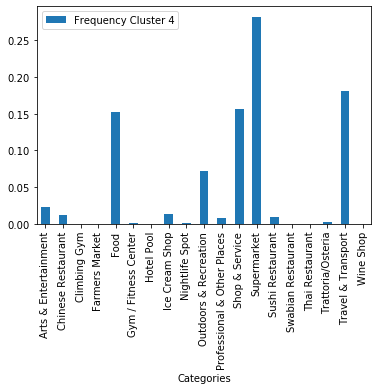

In [80]:
centre_cat.plot(x ='Categories', y='Frequency Cluster 0', kind = 'bar')
centre_cat.plot(x ='Categories', y='Frequency Cluster 1', kind = 'bar')
centre_cat.plot(x ='Categories', y='Frequency Cluster 2', kind = 'bar')
centre_cat.plot(x ='Categories', y='Frequency Cluster 3', kind = 'bar')
centre_cat.plot(x ='Categories', y='Frequency Cluster 4', kind = 'bar')

# The End